Using cpu device
------------------------------
| time/              |       |
|    fps             | 1405  |
|    iterations      | 1     |
|    time_elapsed    | 11    |
|    total_timesteps | 16384 |
------------------------------
--------------------------------------
| time/                   |          |
|    fps                  | 1258     |
|    iterations           | 2        |
|    time_elapsed         | 26       |
|    total_timesteps      | 32768    |
| train/                  |          |
|    approx_kl            | 0.0      |
|    clip_fraction        | 0        |
|    clip_range           | 0.2      |
|    entropy_loss         | -9.93    |
|    explained_variance   | 0        |
|    learning_rate        | 0.00025  |
|    loss                 | 2.68e+21 |
|    n_updates            | 10       |
|    policy_gradient_loss | 6.35e-10 |
|    std                  | 1        |
|    value_loss           | 4.13e+21 |
--------------------------------------
-------------------------

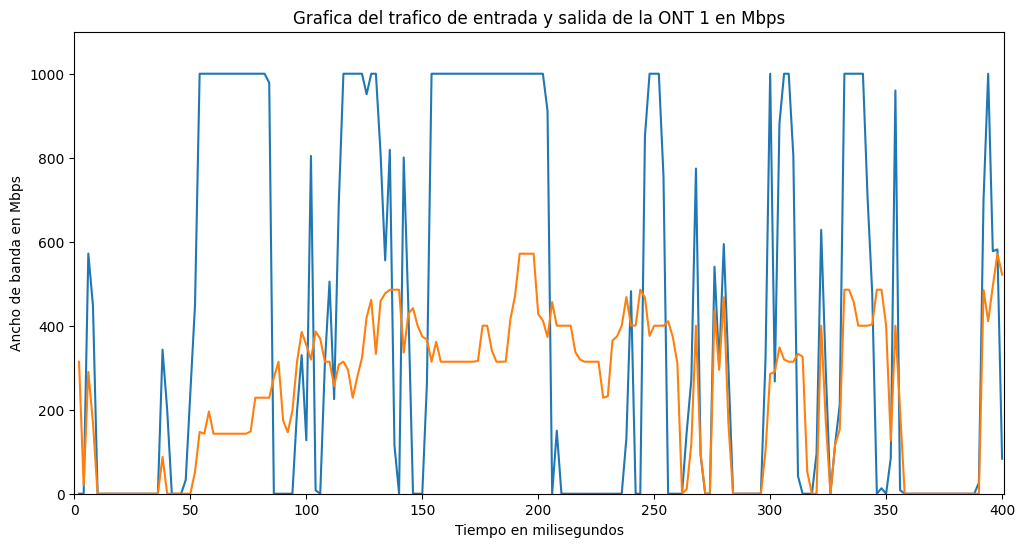

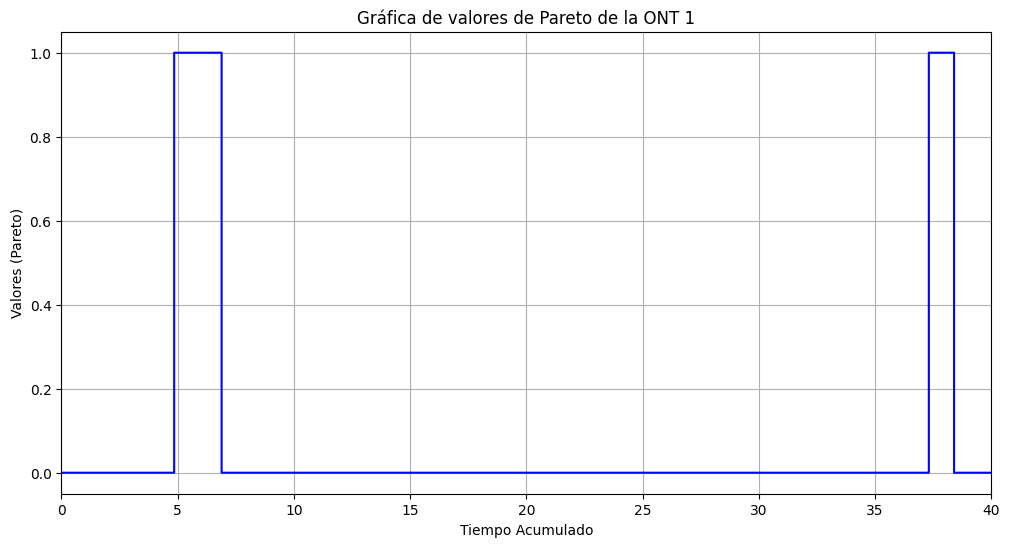

224.90762909484752


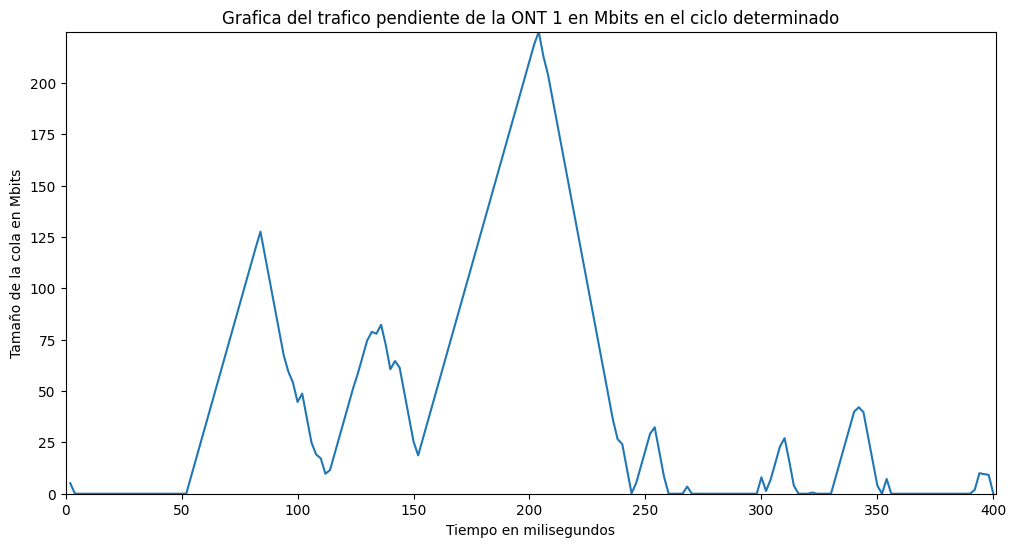

Valores de la ONT 1 de entrada son: [647.1704603596692, 75.85756827319845, 452.553176131719, 206.20863337862437, 0.0, 0.0, 134.70514605806264, 1000.0, 1000.0, 1000.0, 883.2316191675261, 1000.0, 480.2050170125356, 0.0, 254.02315848733903, 0.0, 0.0, 0.0, 130.43836307601097, 800.2284788793166, 912.4541830881741, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 817.8016987549377, 250.79336994730565, 719.457924943375, 264.73252137980217, 0.0, 169.27372173539624, 160.77286341441612, 0.0, 0.0, 0.0, 250.63992290723155, 1000.0, 1000.0, 1000.0, 640.8833412742152, 916.9953596260324, 625.7327780090886, 0.0, 936.37656874929, 319.4590381973264, 463.89611165179423, 0.0, 0.0, 834.3133829122803, 465.0263646223233, 1000.0, 847.3824654655151, 297.2646714181681, 0.0, 0.0, 0.0, 152.5940251079089, 648.0087083724776, 272.42166464374196, 76.16428936690278, 0.0, 0.0, 0.18196012322868604, 448.2162901627104, 291.5293733021298, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

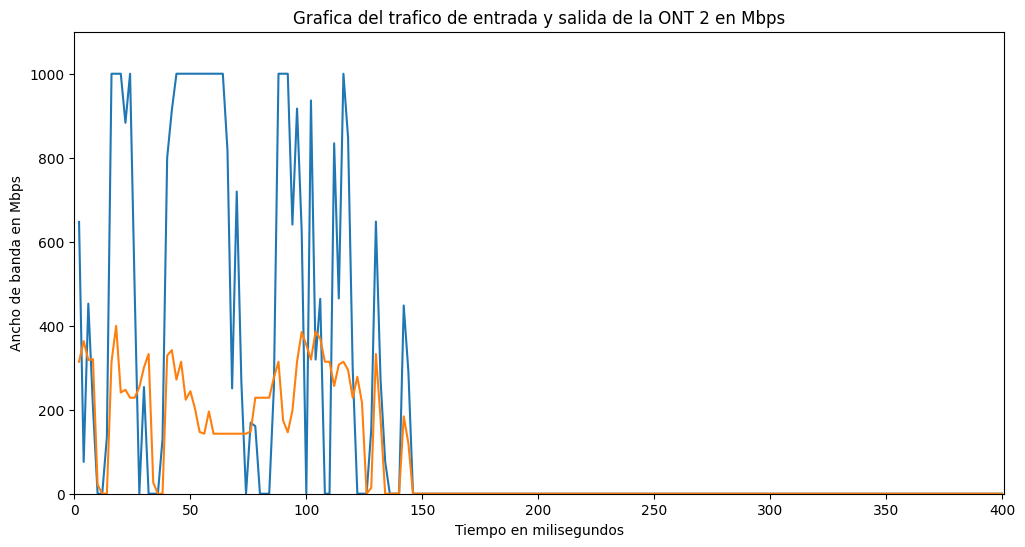

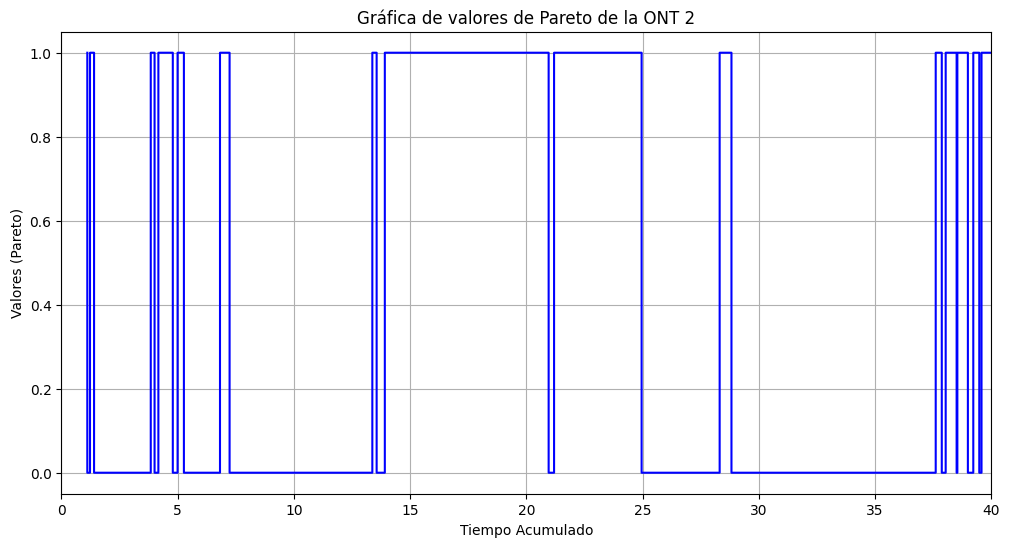

102.60968716107007


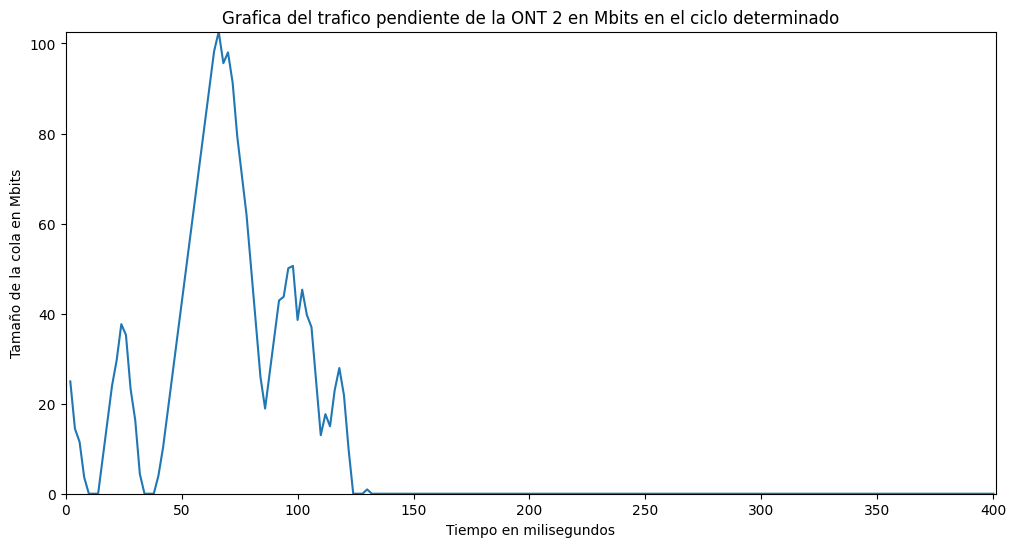

Valores de la ONT 2 de entrada son: [619.6697773180314, 711.8193233987981, 605.2007926375267, 318.81546655160287, 192.6091445905489, 0.0, 0.0, 98.34390292971352, 936.8676665454168, 607.5743186510307, 1000.0, 219.16962517089988, 610.682564109953, 795.4099708728339, 75.0725876104883, 0.0, 0.0, 6.140260621732453, 814.0598577191131, 82.23195020578135, 407.0508963403271, 298.33717757208234, 0.0, 940.0825527293889, 1000.0, 1000.0, 1000.0, 885.7458656271505, 0.0, 866.8027766728379, 1000.0, 950.6015116095435, 1000.0, 1000.0, 1000.0, 1000.0, 178.4006957838621, 0.0, 36.46545336043372, 771.4724333601115, 1000.0, 167.81263770062174, 298.8675135267833, 399.39343968666026, 0.0, 0.0, 0.0, 579.3541666228626, 29.04269582226893, 321.39809456340527, 564.2102121714516, 97.64347334928858, 216.96535366321, 682.4073838721114, 1000.0, 1000.0, 1000.0, 308.59138560701905, 186.2627627427469, 1000.0, 682.3575787536604, 206.12530761892836, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 678.4723024157196, 28.7850252070045

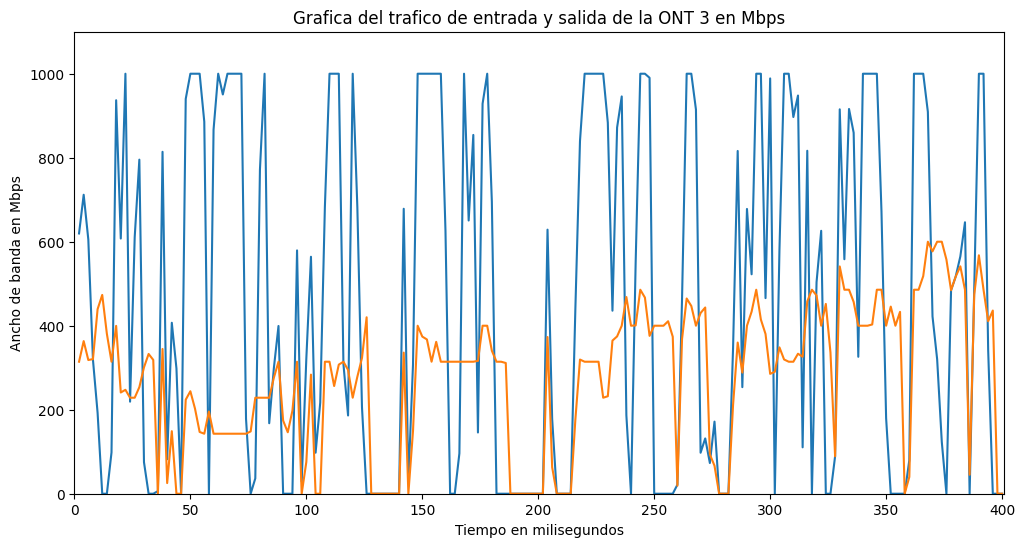

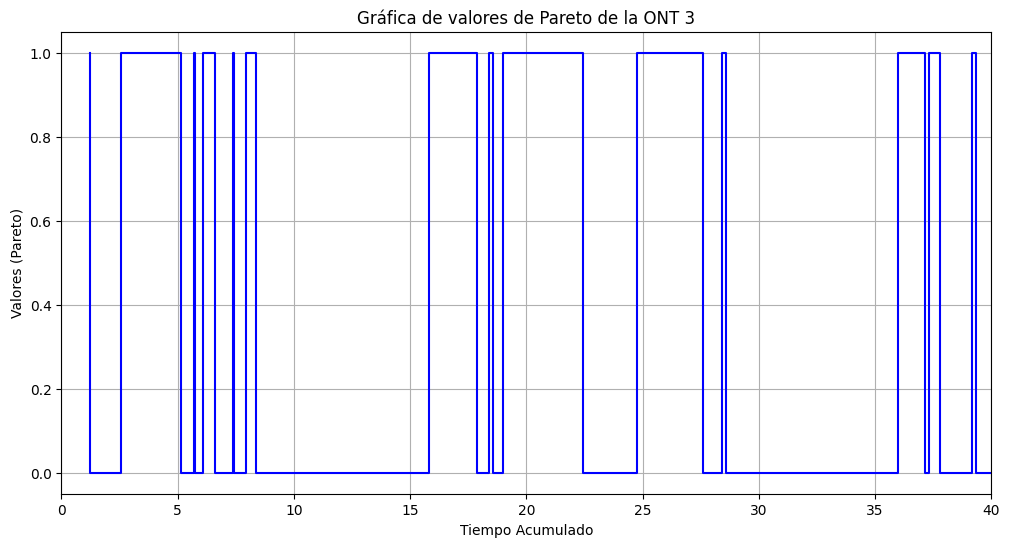

76.86465413128829


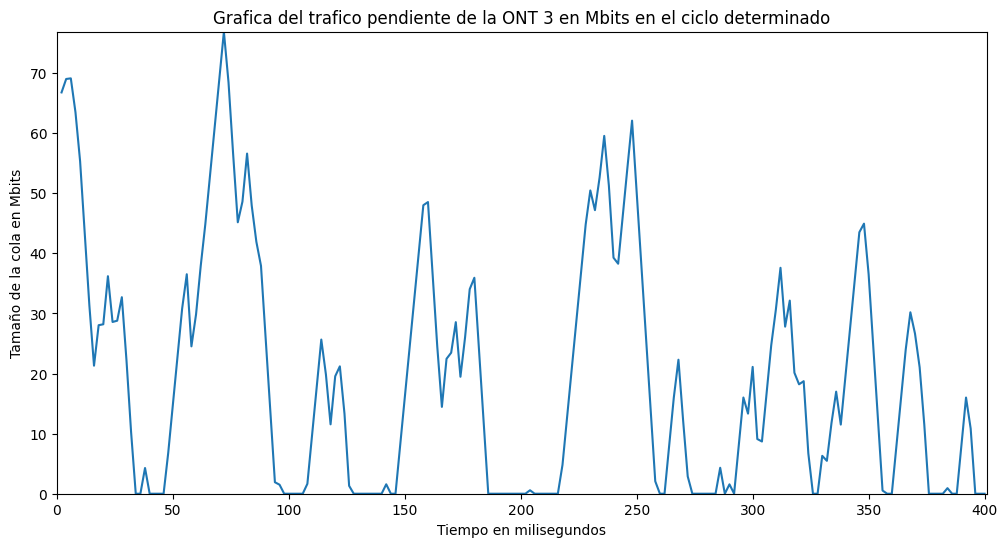

Valores de la ONT 3 de entrada son: [0.0, 196.76249196249043, 0.0, 0.0, 211.05418092596253, 747.551207086991, 300.1512387235119, 276.7535329801525, 0.0, 0.0, 0.0, 5.2099707888595415, 0.0, 0.0, 449.7763584769854, 0.0, 0.0, 0.0, 116.2041631704618, 384.91536757708644, 640.1530636884213, 604.0483683714496, 728.9830163348156, 1000.0, 837.3964327737773, 0.0, 0.0, 0.0, 0.0, 171.61256232470868, 1000.0, 1000.0, 1000.0, 186.0278364699628, 563.5997322262393, 0.0, 285.526629457725, 1000.0, 1000.0, 602.2269777406633, 694.5972460681674, 807.4793688722547, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 302.4812861099964, 0.0, 85.87540328076582, 0.0, 0.0, 513.5046716157906, 486.28394832437624, 0.0, 512.8286809925878, 901.7418449811972, 415.0898352526294, 240.64454474479203, 0.0, 0.0, 636.7013351168788, 429.65074670492885, 107.40806492181154, 0.0, 0.0, 181.0792101537652, 0.0, 0.0, 0.0, 0.0, 298.3797174185877, 0.0, 57.067002856505674, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 945.58

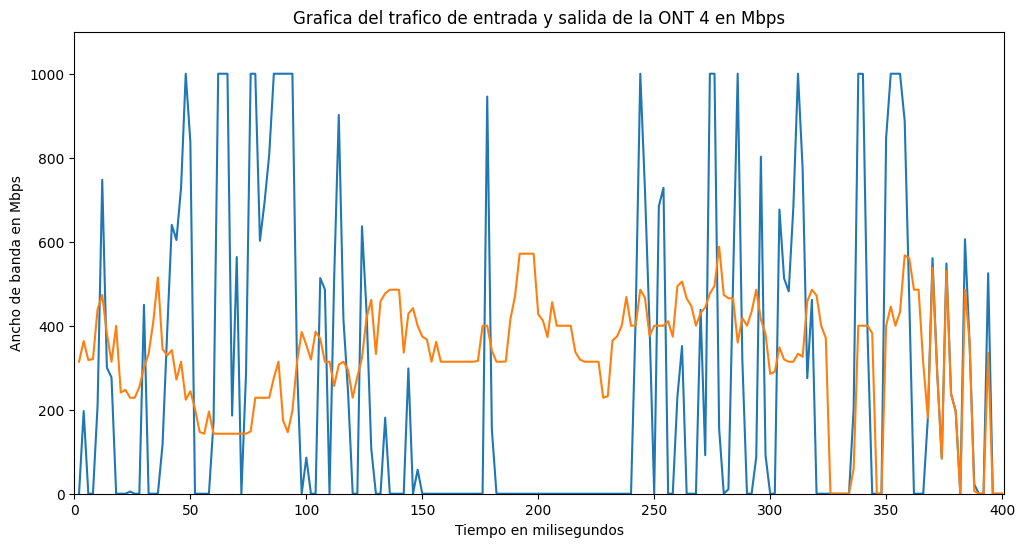

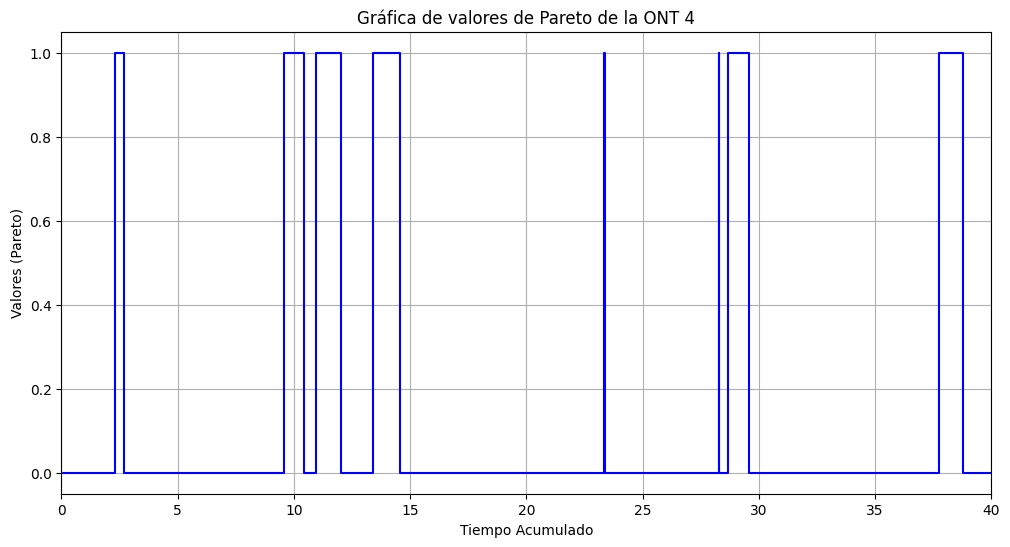

1110.7260222817117


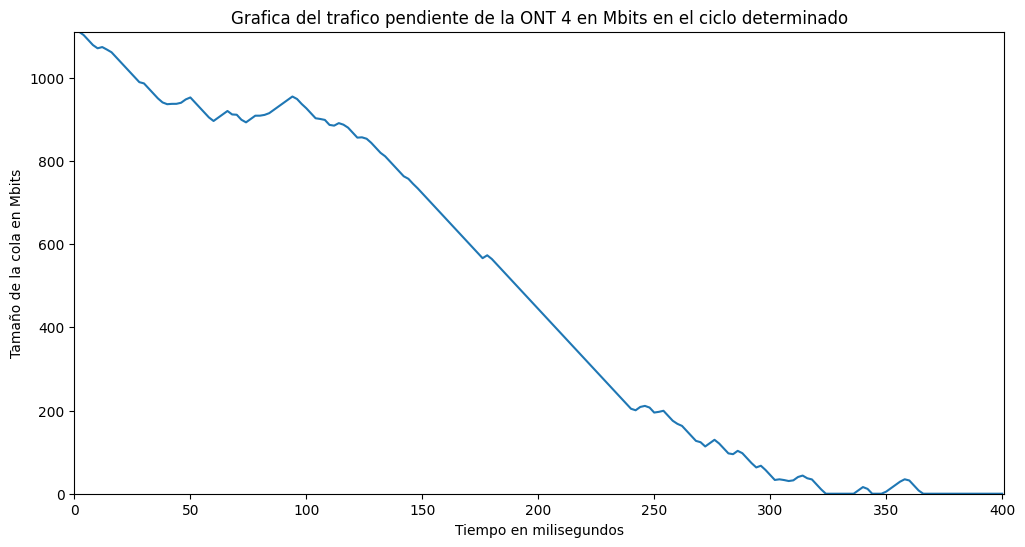

Valores de la ONT 4 de entrada son: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 512.9261388859137, 468.06355747912096, 1000.0, 1000.0, 386.78197155556626, 0.0, 0.0, 206.0101554866365, 389.08550471279455, 0.0, 0.0, 0.0, 798.2401786129273, 744.0427944370682, 970.0683523512412, 338.1322648896387, 215.255384826625, 504.9438391063025, 615.8504743407537, 213.7869790801942, 1000.0, 809.9147544212345, 1000.0, 795.3303532375243, 1000.0, 715.6670641345232, 0.0, 40.61275059148895, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 753.873411761143, 820.4761094904259, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 405.27033744469423, 48.50702721469391, 0.0, 136.95505819908593, 850.1012314267825, 0.0, 155.3637192768779, 48.2152971548242, 0.0, 470.3230420728961, 0.0, 495.9783497149255, 1000.0, 999.9597185902618, 189.15566979169742, 1000.0, 1000.0, 981.0834766292147, 1000.0, 1000.0, 418.4619643810801, 460.33812601816516, 978.0493889185973, 1000.0, 929.2841275208721, 303.43520370753697, 110.80815845507097, 0.0, 0.0, 

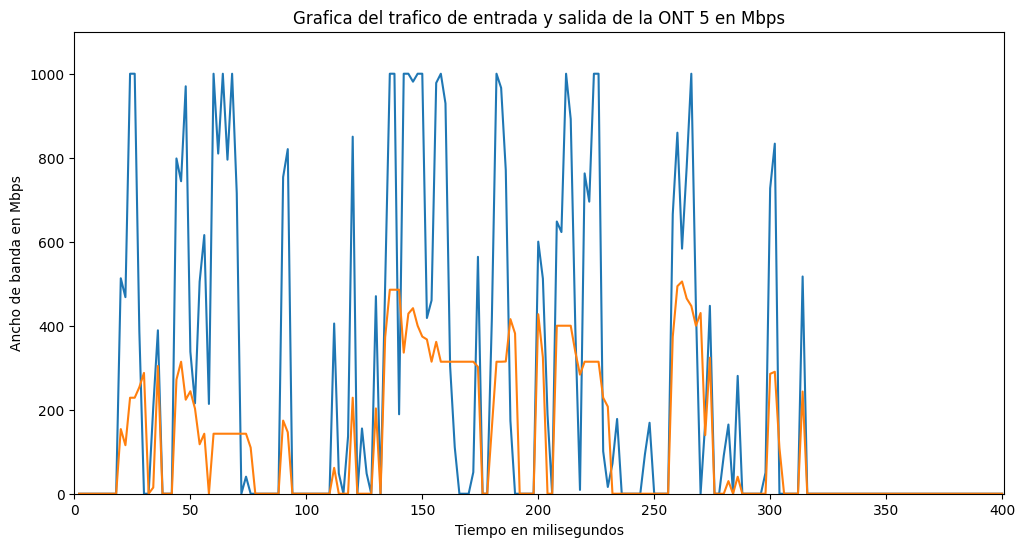

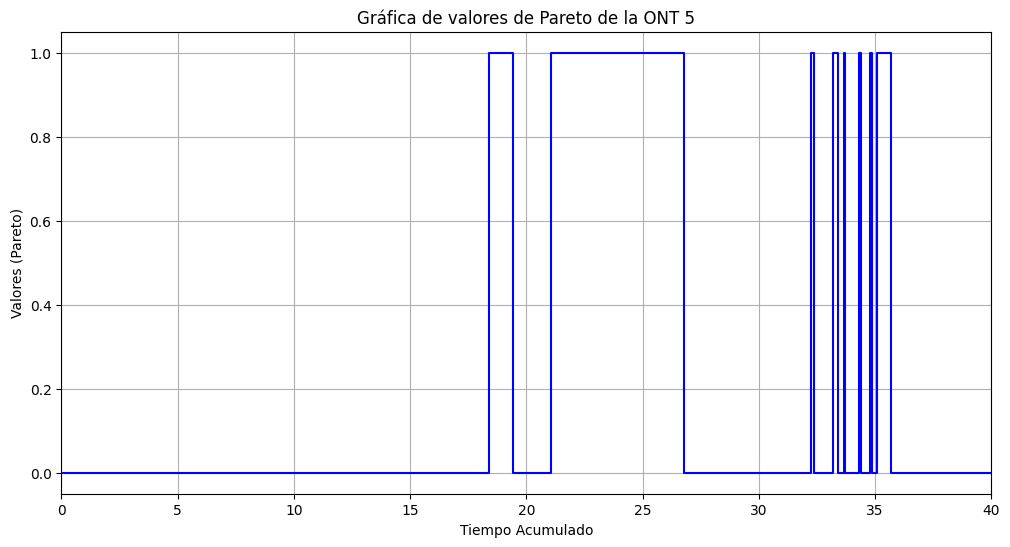

63.126649188162816


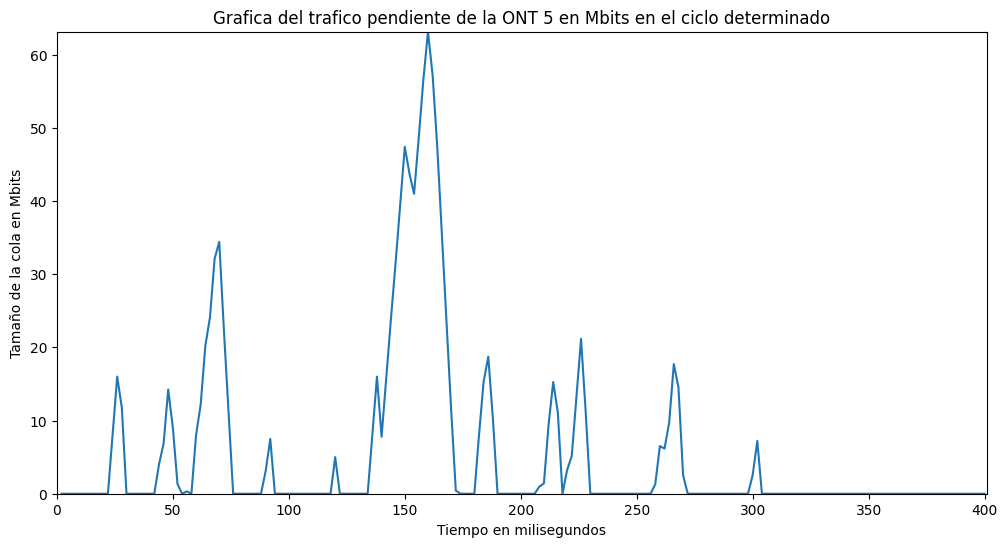

Valores de la ONT 5 de entrada son: [919.180428553751, 1000.0, 990.3720433426499, 823.8607346150424, 182.2109586226809, 0.0, 306.17467574783876, 580.6558597247449, 0.0, 864.5992948836213, 785.5086978961692, 905.4147969690093, 268.62726372829013, 0.0, 106.85449971129945, 470.5615471191404, 205.3308410840621, 0.0, 514.0489661916746, 1000.0, 731.1816167839518, 563.4098340290477, 495.57755727262906, 245.22098381364978, 217.62113888603594, 332.5655202832341, 1000.0, 941.3063279482516, 817.7509195042132, 1000.0, 1000.0, 1000.0, 869.2756429923562, 192.83637924842378, 858.7876577173289, 841.4116400516954, 748.4335039722911, 0.0, 0.0, 245.28682333675044, 352.2596694637517, 0.0, 0.0, 0.0, 380.93821779511376, 575.7619378553092, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 619.6577927500018, 677.6758093154549, 956.1110279212071, 234.98660307633634, 0.0, 0.0, 0.0, 0.0, 0.0, 411.11300021514995, 550.4634789377366, 734.0730244463721, 336.4070025499084, 89.2860553512702, 0.0, 0.0, 0.0, 0.0, 

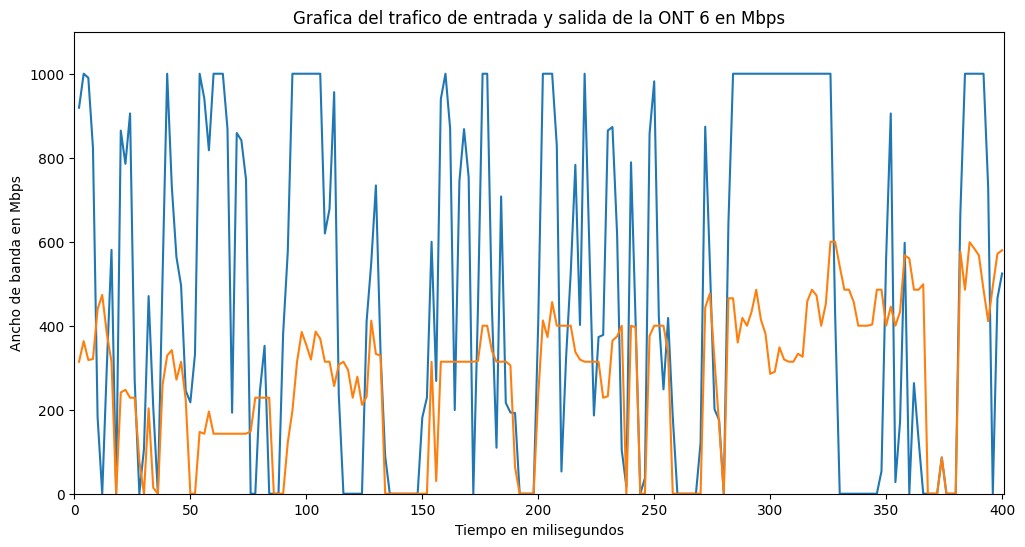

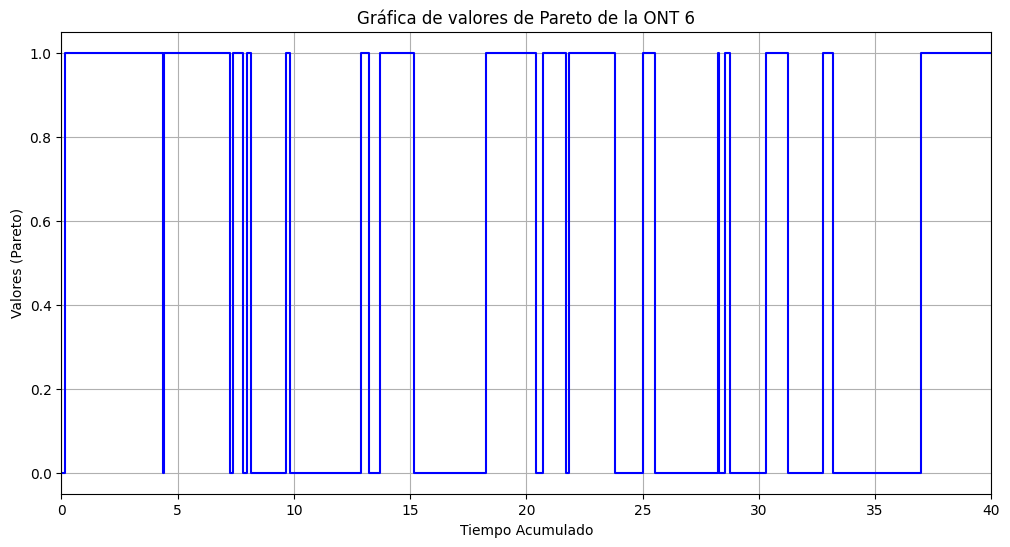

176.87254095075406


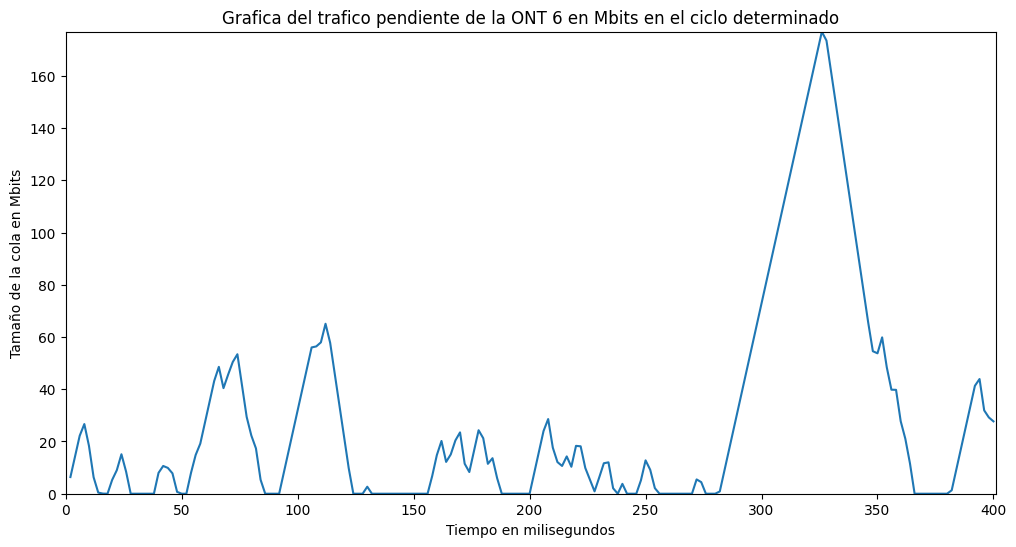

Valores de la ONT 6 de entrada son: [0.0, 0.0, 0.0, 107.99304530361388, 142.20481425625977, 86.53770886472932, 791.7225583542827, 578.5284156487052, 591.0617539666296, 755.9308800715577, 1000.0, 694.160746860073, 1000.0, 1000.0, 872.1114231522124, 518.4378622708259, 732.5600816998646, 301.7093555370689, 1000.0, 372.15952878450145, 448.0059309210919, 1000.0, 1000.0, 1000.0, 702.0241570732227, 965.2794109095438, 693.2759384971264, 0.0, 0.0, 135.8956404377136, 1000.0, 982.533350775936, 759.7166279884116, 1000.0, 1000.0, 1000.0, 1000.0, 626.2242106922299, 844.1574729065479, 77.6756070440472, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 677.2626417004091, 699.07955729383, 0.0,

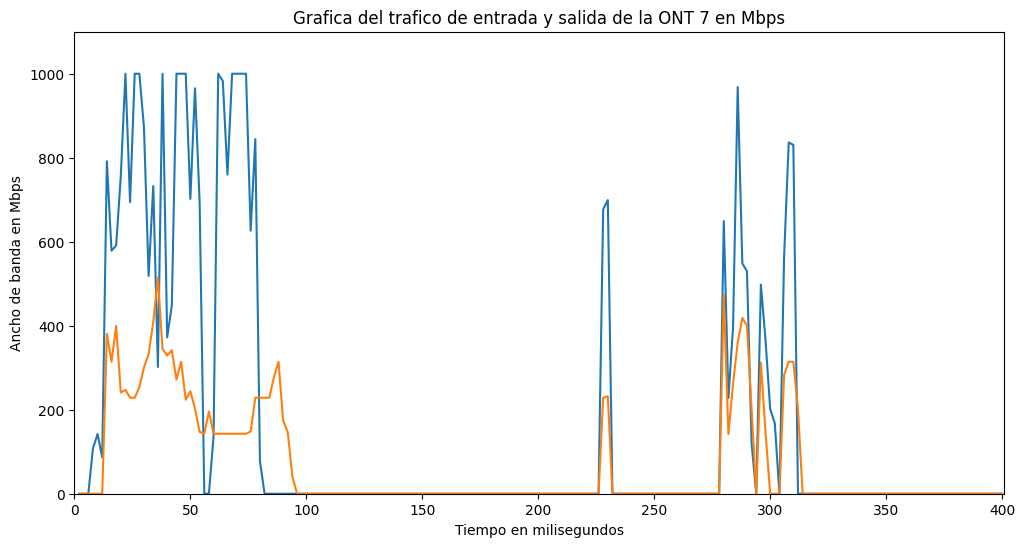

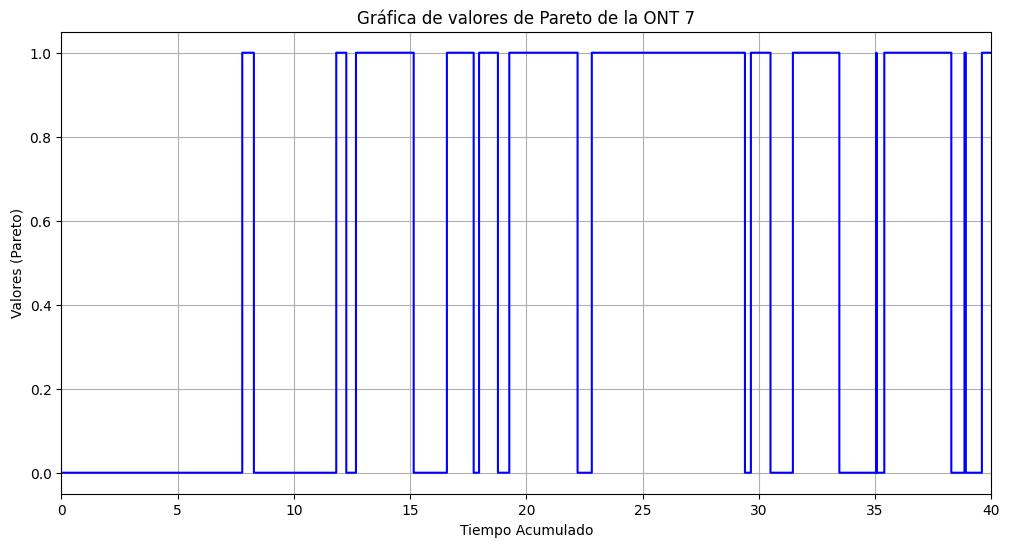

91.30990689269755


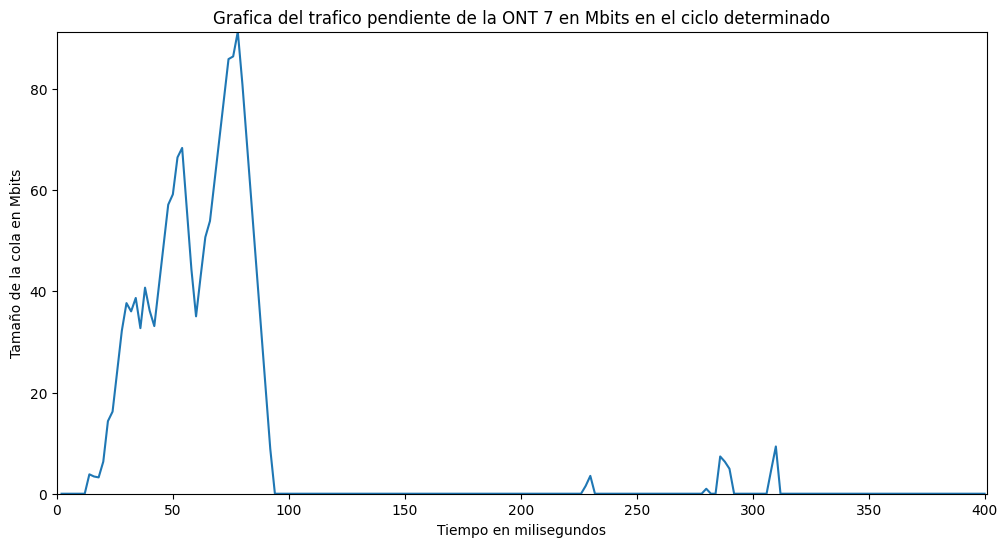

In [4]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.utils import set_random_seed
from custom_env.redes_opticas_env import RedesOpticasEnv

def make_env(num_ont, Vt=10e6,Vt_contratada=10e6/10, rank=0, seed=0):
    """
    Utility function for multiprocessed env.
    
    :param num_ont: Número de ONTs en la red
    :param Vt: Capacidad de tráfico
    :return: un entorno con configuración específica
    """
    def _init():
        env = RedesOpticasEnv(render_mode=None, num_ont=num_ont, Vt=Vt, Vt_contratada=Vt_contratada)
        return env
    return _init

def transpuesta(list_ont):
     #Hay que hacer la matriz transpuesta de la lista

    np_array = np.array(list_ont)

    # Transponer el array
    transposed_np_array = np_array.T

    # Convertir el array transpuesto de NumPy de nuevo a una lista de listas de Python
    list_transpuesta = transposed_np_array.tolist()

    return list_transpuesta


def grafico_pareto(valores_instantes, ont):

    valoresInstantesFinales=[]
    valoresPareto=[]

    # Modificar los valores de Pareto en posiciones pares donde el instante es 0
    for i in valores_instantes:
        cont=0
        for j in i:
            if cont%2==0:
                if j==0:
                    valoresInstantesFinales.append(j)
                    valoresPareto.append(0)
                else:
                    valoresInstantesFinales.append(j)
                    valoresPareto.append(1)
            else:
                if j==0:
                    valoresInstantesFinales.append(j)
                    valoresPareto.append(0)
                else:
                    valoresInstantesFinales.append(j)
                    valoresPareto.append(0)

            cont+=1


    # Crear una lista extendida para los instantes y valores Pareto
    extended_instantes = []  # Comenzar desde tiempo 0
    extended_pareto = []
    
    current_time = 0  # Tiempo acumulado actual
    
    # Añadir valores extendidos para mantener el gráfico en el eje y hasta el siguiente instante
    for i, valor in enumerate(valoresInstantesFinales):
        current_time += valor
        # Añadir el tiempo actual y su valor correspondiente de Pareto
        extended_instantes.append(current_time)
        if i < len(valoresPareto) - 1:
            extended_pareto.append(valoresPareto[i])
            extended_instantes.append(current_time)
            extended_pareto.append(valoresPareto[i+1])
        else:
            extended_pareto.append(valoresPareto[i])
    
    # Graficar
    plt.figure(figsize=(12, 6))
    plt.step(extended_instantes, extended_pareto, where='post', linestyle='-', color='blue')
    plt.xlabel('Tiempo Acumulado')
    plt.ylabel('Valores (Pareto)')
    plt.title(f'Gráfica de valores de Pareto de la ONT {ont+1}')
    plt.xlim([0,n_ciclos/5])
    plt.grid(True)
    plt.show()

#Funcion auxiliar para el array de los instantes de los ciclos y luego calcular la grafica de barras
def funcion_aux(array_valores):

    x=[[] for i in range(num_ont)]
    #y=[[] for i in range(num_ont)]

    for i, subarray in enumerate(array_valores):
        #print(f"Posición {i}:")
        # Iterar sobre cada subarray en la posición actual
        for j, sublist in enumerate(subarray):
            #print(f"    Subarray {j}:")
            # Iterar sobre cada valor en el subarray actual
            for k, valor in enumerate(sublist):
                #print(f"        Valor {k}: {valor}")
                x[j].append(valor)

    #print(f"Los valores de los instantes en la ont 1 son de x: {x[0]}")

    return x


if __name__ == "__main__":
    env_id = 'RedesOpticasEnv-v0'  # Hay que asegurarse de que este ID coincida con el registrado
    num_test = 20  #Ponemos el numero de test que necesitamos para que el algoritmo de aprendizaje aprenda.
    seed = np.random.randint(0, 10)  #Ponemos seeds aleatorias
    num_envs = 1  # Número de entornos paralelos
    #EL NUMERO DE ONTS PUEDE SER DEFINIDO DESDE ESTA VARIABLE(POSIBLE INPUT)
    #num_ont=int(input("Introduce el numero de unidades opticas(ont): "))
    num_ont=7
    #Establecemos el Vt
    #Vt=float(input("Introduce la velocidad de transmision maxima: "))
    Vt=10e9
    #Transmision de cada ciclo
    T=0.002
    #OLT Capacity
    OLT_Capacity=Vt*T
    #Velocidad de transmision contratada, lo ponemos a Vt/5 del Vt de la OLT inicialmente, lo que deberia de ser de maximo 2*10e8 lo que serian 200Mbps
    Vt_contratada=6000000000
    #Maximo de bits que se pueden transmitir en un ciclo en cada ont por la limitacion de la velocidad contratada
    Max_bits_ONT=Vt_contratada*T
    #Numero de ciclos que se van a ejecutar
    n_ciclos=int(input("Cuantos ciclos quiere ver: "))

    # Vector con los entornos establecidos
    vec_env = DummyVecEnv([make_env(num_ont, Vt,Vt_contratada, rank=i, seed=42) for i in range(num_envs)])
    
    
    n_steps = 16384  # Steps por actualización
    batch_size = 256  # Tamaño del mini-batch (16384 es múltiplo de 256)

    # Definir el modelo PPO con los parámetros ajustados
    model = PPO(
        "MlpPolicy",
        vec_env,
        verbose=1,
        n_steps=n_steps,  # Steps por actualización
        batch_size=batch_size,  # Tamaño del mini-batch
        learning_rate=0.00025,
        gamma=0.99,
        gae_lambda=0.95
    )
    model.learn(total_timesteps=50000)

    # Fase de pruebas

    #Establecemos un unico episodio a investigar
    num_test_episodes = 1  # Número de episodios de prueba

    # Lista para guardar la información de cada episodio
    episode_info = []  

    # Lista de en cada ont guardar el valor de su capacidad, de entrada salida y del pendiente(entrada-salida)
    list_ont = []
    list_ont_2 = []
    list_pendiente=[]

    # Guardar los estados de ON y OFF del estado de pareto
    estados_on_off_recolectados = []

    #Capacidad de la OLT
    tamano_cola=[]

    
    obs = vec_env.reset()  # Resetea el entorno al estado inicial
    for episode in range(num_test_episodes):
        
        done = np.array([False]*num_envs)  # Inicializa 'done' para todos los entornos
        step_counter = 0  # Contador de steps para limitar a 100

        while step_counter < n_ciclos:
            

            action, _states = model.predict(obs, deterministic=True)  # Usamos el modelo para predecir la acción
            obs, rewards, dones, info = vec_env.step(action)

            # Guardamos la información del episodio.
            episode_info.append(info)
            for i in range(len(info)):  # Itera sobre cada sub-entorno
                
                suma = 0

                list_ont.append(info[i]['trafico_entrada'])
                list_ont_2.append(info[i]['trafico_salida'])
                list_pendiente.append(info[i]['trafico_pendiente'])
                estados_on_off_recolectados.append(info[i]['trafico_IN_ON_actual'])
            
            done |= dones  # Actualiza 'done' para todos los entornos
            step_counter += 1  # Incrementa el contador de steps


    #Hallamos el valor de la lista transpuesta, para los valores de entrada y de salida
    list_transpuesta=transpuesta(list_ont)

    # Convertir list_transpuesta a un array NumPy y dividir por 0.002
    #0.002*10e6(transformacion de bps a Mbps)=20000
    array_transpuesta = np.array(list_transpuesta) / 20000

    # Convertir array_transpuesta de vuelta a una lista de listas si es necesario
    list_valores_entrada = array_transpuesta.tolist()

    list_transpuesta_2=transpuesta(list_ont_2)

    
    # Convertir list_transpuesta a un array NumPy y dividir por 0.002
    #0.002*10e6(transformacion de bps a Mbps)=20000
    array_transpuesta_2 = np.array(list_transpuesta_2) / 20000

    # Convertir array_transpuesta de vuelta a una lista de listas si es necesario
    list_valores_salida = array_transpuesta_2.tolist()

    list_pendiente_transpuesta=transpuesta(list_pendiente)

    # Convertir list_transpuesta a un array NumPy y dividir por 0.002
    #0.002*1e6(transformacion de bps a Mbps)=20000
    array_pendiente_transpuesta = np.array(list_pendiente_transpuesta) / 1000000

    # Convertir array_transpuesta de vuelta a una lista de listas si es necesario
    list_pendiente_fin = array_pendiente_transpuesta.tolist()

    maximo_pendiente=[]

    #Hallamos el valor maximo de cada ciclo en cada ont para las graficas
    for i in range(num_ont):
        maximo_pendiente.append(max(list_pendiente_fin[i]))

    #Hallar valores de los instantes para el grafico de barras
    valoresInstantes=funcion_aux(estados_on_off_recolectados)

    #Graficas

    for i in range(num_ont):
        
        print(f"Valores de la ONT {i} de entrada son: {list_valores_entrada[i]}")
        print(f"Valores de la ONT {i} de salida son: {list_valores_salida[i]}")
        
        print(f"Los valores de los instantes de la ont {i+1} son de {valoresInstantes[i]}")

        nuevo_x = np.arange(2, 2 * n_ciclos + 1, 2)  # x se duplica para cada punto

        # Configurando las marcas del eje x para que aparezcan de dos en dos ciclos
        #plt.xticks(nuevo_x)

        #Grafica del trafico de pareto de las redes
        plt.figure(figsize=(12, 6))
        plt.ylim(0,1100)
        plt.xlim(0, 2 * n_ciclos + 1)  # Ajustamos xlim para acomodar el nuevo rango de x
        plt.xlabel('Tiempo en milisegundos')
        plt.ylabel('Ancho de banda en Mbps')
        plt.plot(nuevo_x, list_valores_entrada[i], label=f'Grafica de la ONT {i+1}')
        plt.plot(nuevo_x, list_valores_salida[i], label=f'Grafica del trafico de entrada y salida de la ONT {i+1}')
        plt.title(f'Grafica del trafico de entrada y salida de la ONT {i+1} en Mbps')
        plt.show()

        #Hacemos una funcion para la realizacion correcta de los valores para la grafica de pareto de ON y OFF de cada ONT
        grafico_pareto(valoresInstantes[i], i)

        #Grafica del trafico pendiente de la ont determinada
        plt.figure(figsize=(12, 6))
        print(maximo_pendiente[i])
        plt.ylim(0,maximo_pendiente[i])
        plt.xlim(0, 2 * n_ciclos + 1)  # Ajustamos xlim para acomodar el nuevo rango de x
        plt.xlabel('Tiempo en milisegundos')
        plt.ylabel('Tamaño de la cola en Mbits')
        plt.plot(nuevo_x,list_pendiente_fin[i], label=f'Grafica del trafico pendiente de la ONT {i+1}')
        plt.title(f'Grafica del trafico pendiente de la ONT {i+1} en Mbits en el ciclo determinado')
        plt.show()
        

